In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
HUGGINGFACE_ACCESS_TOKEN=""

recovery_train = pd.read_csv( 'ReCOVery_train.csv')
recovery_test = pd.read_csv('ReCOVery_test.csv')

fakehealth_train = pd.read_csv( 'FakeHealth_train.csv')
fakehealth_test = pd.read_csv( 'FakeHealth_test.csv')

In [4]:
# Concatenate train and test sets for each dataset
recovery_combined = pd.concat([recovery_train, recovery_test], ignore_index=True)
fakehealth_combined = pd.concat([fakehealth_train, fakehealth_test], ignore_index=True)

print(recovery_combined.shape)
print(fakehealth_combined.shape)

recovery_combined["text"] = recovery_combined["title"] + " " + recovery_combined["news"]
fakehealth_combined["text"] = fakehealth_combined["title"] + " " + fakehealth_combined["news"]

(2029, 6)
(2092, 9)


In [10]:
model_names = {
    "LLaMA-3.2": "meta-llama/Llama-3.2-1B-Instruct",
    "Falcon3": "tiiuae/Falcon3-3B-Instruct",
    "Qwen2.5": "Qwen/Qwen2.5-0.5B-Instruct",
    "Phi-3.5": "microsoft/Phi-3.5-mini-instruct"
}

tokenizers = {name: AutoTokenizer.from_pretrained(path, token=HUGGINGFACE_ACCESS_TOKEN) for name, path in model_names.items()}

In [11]:
def count_tokens(text, tokenizer):
    if pd.isna(text):
        return 0
    return len(tokenizer.tokenize(str(text)))

for model_name, tokenizer in tokenizers.items():
    recovery_combined[f"num_tokens_{model_name}"] = recovery_combined["text"].apply(lambda x: count_tokens(x, tokenizer))
    fakehealth_combined[f"num_tokens_{model_name}"] = fakehealth_combined["text"].apply(lambda x: count_tokens(x, tokenizer))


LLaMA-3.2  avg-recovery: 1070.3647116806308
LLaMA-3.2  avg-fakehealth: 921.2700764818355
Falcon3  avg-recovery: 1139.6835879743717
Falcon3  avg-fakehealth: 950.0239005736138
Qwen2.5  avg-recovery: 1090.6352883193692
Qwen2.5  avg-fakehealth: 938.5200764818355
Phi-3.5  avg-recovery: 1306.408575653031
Phi-3.5  avg-fakehealth: 1114.17017208413


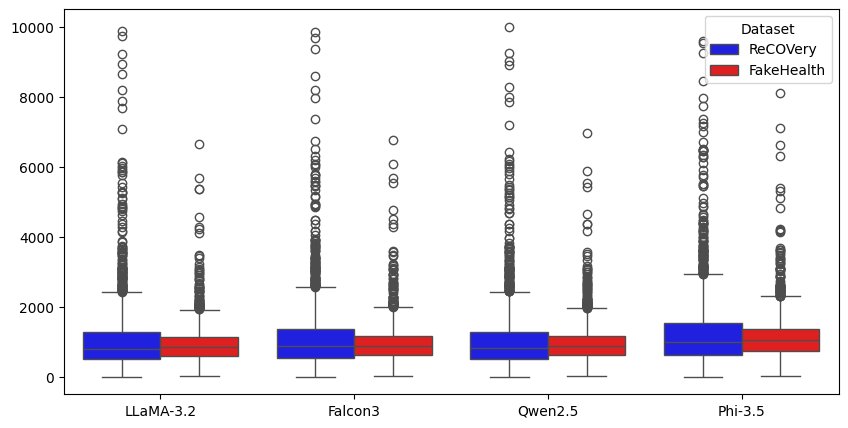

In [21]:
token_threshold = 10000
plot_data = []
for model_name in model_names.keys():
    recovery_filtered = recovery_combined[recovery_combined[f"num_tokens_{model_name}"] <= token_threshold]
    fakehealth_filtered = fakehealth_combined[fakehealth_combined[f"num_tokens_{model_name}"] <= token_threshold]
    print(model_name, " avg-recovery:", sum(recovery_combined[f"num_tokens_{model_name}"])/len(recovery_combined[f"num_tokens_{model_name}"]))
    print(model_name, " avg-fakehealth:", sum(fakehealth_filtered[f"num_tokens_{model_name}"])/len(fakehealth_filtered[f"num_tokens_{model_name}"]))
    plot_data.append(pd.DataFrame({
        "LLM": model_name,
        "Tokens": recovery_filtered[f"num_tokens_{model_name}"],
        "Dataset": "ReCOVery"
    }))

    plot_data.append(pd.DataFrame({
        "LLM": model_name,
        "Tokens": fakehealth_filtered[f"num_tokens_{model_name}"],
        "Dataset": "FakeHealth"
    }))

plot_df = pd.concat(plot_data, ignore_index=True)

plt.figure(figsize=(10, 5))
sns.boxplot(x="LLM", y="Tokens", hue="Dataset", data=plot_df, palette={"ReCOVery": "blue", "FakeHealth": "red"})


# Remove x-axis and y-axis titles
plt.xlabel("")
plt.ylabel("")


# plt.legend(title="Dataset")
# plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("tokens_distribution.png")
plt.savefig("tokens_distribution.pdf", format="pdf", bbox_inches='tight')
plt.show()
